>> Judy Nabil 7575

>> Amr Abdelaziz 7447

>> Ahmed Hany 7387

>> Mahmoud Haytham 7560

## Assignment 2

## Skin Cancer Classification and Segmentation

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ham1000-segmentation-and-classification/GroundTruth.csv
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0030912.jpg
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0028933.jpg
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0030585.jpg
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0028394.jpg
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0033697.jpg
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0030062.jpg
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0031213.jpg
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0027799.jpg
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0028100.jpg
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0027960.jpg
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_0028872.jpg
/kaggle/input/ham1000-segmentation-and-classification/images/ISIC_003131

Import needed libraries

In [3]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## Data Loading

In [4]:
# Set the data path (adjust as needed for your Kaggle environment)
DATA_PATH = "/kaggle/input/ham1000-segmentation-and-classification"

# Read the metadata CSV file
csv_path = os.path.join(DATA_PATH, "GroundTruth.csv")
df = pd.read_csv(csv_path)
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


change labels into only one column

In [5]:
# Assume the CSV contains one-hot encoded columns for the 7 classes:
label_cols = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

# Convert one-hot encoding to a single label (assumes exactly one column is 1 per row)
if set(label_cols).issubset(df.columns):
    df["label"] = df[label_cols].idxmax(axis=1)
else:
    # If not present, assume there is already a 'label' column.
    print("One-hot columns not found. Using existing 'label' column.")
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


Map label column to integers

In [6]:
# Map string labels to integers (0-6)
label_mapping = {"MEL": 0, "NV": 1, "BCC": 2, "AKIEC": 3, "BKL": 4, "DF": 5, "VASC": 6}
df["label_idx"] = df["label"].map(label_mapping)
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label,label_idx
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,1
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,0


## Data Splitting

In [7]:
# Split the data: 70% train, 15% validation, 15% test (stratified by label)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df["label_idx"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label_idx"])


## Data Processing

In [8]:
class HAM10000Dataset(Dataset):
    def __init__(self, df, img_folder, mask_folder=None, transform=None, mode='classification'):
        """
        Args:
            df (DataFrame): DataFrame containing image names and labels.
            img_folder (str): Path to the folder with images.
            mask_folder (str, optional): Path to the folder with masks.
            transform (callable, optional): Transformations to apply to images (and masks).
            mode (str): 'classification' returns (image, label),
                        'segmentation' returns (image, mask, label).
        """
        self.df = df
        self.img_folder = img_folder
        self.mask_folder = mask_folder
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_folder, row['image'] + '.jpg')
        image = cv2.imread(img_path)
        
        if image is None:
            raise FileNotFoundError(f"Image not found at {img_path}")
            
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)
            
        label = row['label_idx']

        # if mode is segmentation
        if self.mode == 'segmentation' and self.mask_folder is not None:
            mask_path = os.path.join(self.mask_folder, row['image'] + '_segmentation.png')
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            if mask is None:
                raise FileNotFoundError(f"Mask not found at {mask_path}")
                
            mask = Image.fromarray(mask)
            
            if self.transform:
                mask = self.transform(mask)
                
            return image, mask, label
            
        # if mode is classification
        else:  
            return image, label

In [9]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [10]:
# Define image and mask folders (adjust if necessary)
img_folder = os.path.join(DATA_PATH, "images")
mask_folder = os.path.join(DATA_PATH, "masks")


In [11]:
# Create datasets for classification and segmentation modes
train_dataset_cls = HAM10000Dataset(train_df, img_folder, transform=transform, mode='classification')
val_dataset_cls   = HAM10000Dataset(val_df,   img_folder, transform=transform, mode='classification')
test_dataset_cls  = HAM10000Dataset(test_df,  img_folder, transform=transform, mode='classification')

train_dataset_seg = HAM10000Dataset(train_df, img_folder, mask_folder, transform=transform, mode='segmentation')
val_dataset_seg   = HAM10000Dataset(val_df,   img_folder, mask_folder, transform=transform, mode='segmentation')
test_dataset_seg  = HAM10000Dataset(test_df,  img_folder, mask_folder, transform=transform, mode='segmentation')


In [12]:
# Create DataLoaders
train_loader_cls = DataLoader(train_dataset_cls, batch_size=32, shuffle=True, num_workers=4)
val_loader_cls   = DataLoader(val_dataset_cls, batch_size=32, shuffle=False, num_workers=4)
test_loader_cls  = DataLoader(test_dataset_cls, batch_size=32, shuffle=False, num_workers=4)

train_loader_seg = DataLoader(train_dataset_seg, batch_size=16, shuffle=True, num_workers=4)
val_loader_seg   = DataLoader(val_dataset_seg, batch_size=16, shuffle=False, num_workers=4)
test_loader_seg  = DataLoader(test_dataset_seg, batch_size=16, shuffle=False, num_workers=4)


## Classification Model

Call a pretrained model (ResNet18)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 7

# Use a pre-trained ResNet18 with modified final layer
model_cls = models.resnet18(pretrained=True)
model_cls.fc = nn.Linear(model_cls.fc.in_features, num_classes)
model_cls.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
# # Use a pre-trained EfficientNet-B7 with modified final layer
# model_cls = models.efficientnet_b7(pretrained=True)
# num_ftrs = model_cls.classifier[1].in_features  # get the input features of the final linear layer
# model_cls.classifier[1] = nn.Linear(num_ftrs, num_classes)  # replace it with a new linear layer for our classes
# model_cls.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 169MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Print total number of parameters in classification model

In [14]:
# Count and print total parameters of resnet
total_params = sum(p.numel() for p in model_cls.parameters())
print("Total parameters in classification model:", total_params)


Total parameters in classification model: 11180103


In [16]:
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(model_cls.parameters(), lr=1e-4)

In [17]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        Early stops the training if validation loss doesn't improve after a given patience.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss  # we want to minimize loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        # Here you can add model saving code if desired
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        self.val_loss_min = val_loss


Train the model

In [18]:
num_epochs = 30
patience = 5
early_stopping = EarlyStopping(patience=patience, verbose=True)

# Lists to record training history for classification
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    # Training Phase
    model_cls.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader_cls:
        images = images.to(device)
        labels = labels.to(device)
        optimizer_cls.zero_grad()
        outputs = model_cls(images)
        loss = criterion_cls(outputs, labels)
        loss.backward()
        optimizer_cls.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / len(train_loader_cls.dataset)
    train_acc = correct / total

    # Validation Phase
    model_cls.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_preds = []
    all_val_labels = []
    with torch.no_grad():
        for images, labels in val_loader_cls:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model_cls(images)
            loss = criterion_cls(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
    val_loss = val_loss / len(val_loader_cls.dataset)
    val_acc = correct_val / total_val
    
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping check
    early_stopping(val_loss, model_cls)
    if early_stopping.early_stop:
        print("Early stopping triggered for classification!")
        break

Epoch 1/30: Train Loss: 0.6743, Train Acc: 0.7625, Val Loss: 0.5100, Val Acc: 0.8189
Validation loss decreased (inf --> 0.510005). Saving model ...
Epoch 2/30: Train Loss: 0.3242, Train Acc: 0.8864, Val Loss: 0.5519, Val Acc: 0.8142
EarlyStopping counter: 1 out of 5
Epoch 3/30: Train Loss: 0.1550, Train Acc: 0.9489, Val Loss: 0.5416, Val Acc: 0.8336
EarlyStopping counter: 2 out of 5
Epoch 4/30: Train Loss: 0.0813, Train Acc: 0.9760, Val Loss: 0.5372, Val Acc: 0.8375
EarlyStopping counter: 3 out of 5
Epoch 5/30: Train Loss: 0.0495, Train Acc: 0.9866, Val Loss: 0.5695, Val Acc: 0.8402
EarlyStopping counter: 4 out of 5
Epoch 6/30: Train Loss: 0.0273, Train Acc: 0.9930, Val Loss: 0.5758, Val Acc: 0.8455
EarlyStopping counter: 5 out of 5
Early stopping triggered for classification!


Evaluate the model

In [19]:
# Final Evaluation on Test Set for Classification
model_cls.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader_cls:
        images = images.to(device)
        outputs = model_cls(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        
acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
print("Test Accuracy:", acc)
# print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=list(label_mapping.keys())))


Test Accuracy: 0.8429807052561543

Classification Report:
               precision    recall  f1-score   support

         MEL       0.66      0.57      0.61       167
          NV       0.88      0.96      0.92      1006
         BCC       0.78      0.83      0.81        77
       AKIEC       0.76      0.39      0.51        49
         BKL       0.76      0.56      0.64       165
          DF       0.72      0.76      0.74        17
        VASC       0.94      0.68      0.79        22

    accuracy                           0.84      1503
   macro avg       0.79      0.68      0.72      1503
weighted avg       0.83      0.84      0.83      1503



- Plot loss/accuracy curves

- plot Confusion matrix

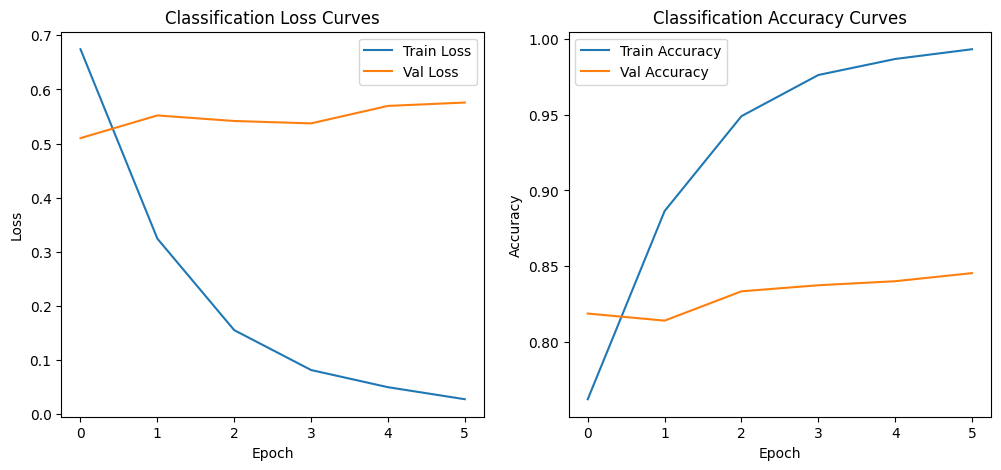

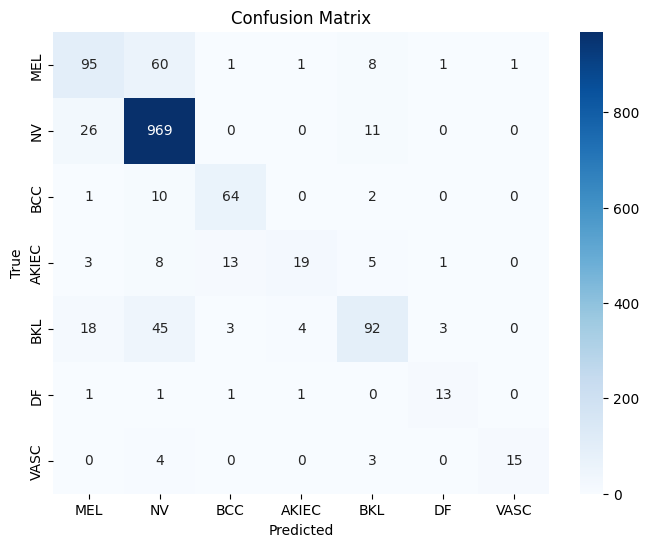

In [21]:
import seaborn as sns

# Classification Training Curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy Curves')
plt.legend()
plt.show()

# Confusion Matrix for Classification
labels_order = list(label_mapping.keys())
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_order, yticklabels=labels_order)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Segmentation model

In [22]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)
        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        out = self.conv_final(d1)
        return out


In [23]:
model_seg = UNet(in_channels=3, out_channels=1)
model_seg.to(device)

criterion_seg = nn.BCEWithLogitsLoss()
optimizer_seg = optim.Adam(model_seg.parameters(), lr=1e-4)

Functions for IOU and Dice coefficient

In [24]:
def iou_score(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection
    return (intersection / (union + 1e-6)).mean().item()

def dice_coeff(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    return (2 * intersection / (pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) + 1e-6)).mean().item()


Train the model

In [26]:
num_epochs_seg = 10
patience_seg = 3
early_stopping_seg = EarlyStopping(patience=patience_seg, verbose=True)

# Lists to record segmentation history
train_seg_loss_history = []
val_seg_loss_history = []
val_seg_iou_history = []
val_seg_dice_history = []


for epoch in range(num_epochs_seg):
    # Training Phase for Segmentation
    model_seg.train()
    running_loss = 0.0
    for images, masks, _ in train_loader_seg:
        images = images.to(device)
        masks = masks.to(device)
        optimizer_seg.zero_grad()
        outputs = model_seg(images)
        loss = criterion_seg(outputs, masks)
        loss.backward()
        optimizer_seg.step()
        running_loss += loss.item() * images.size(0)
    train_loss_seg = running_loss / len(train_loader_seg.dataset)
    
    # Validation Phase for Segmentation
    model_seg.eval()
    val_loss_seg = 0.0
    total_iou_val = 0.0
    total_dice_val = 0.0
    count_val = 0
    with torch.no_grad():
        for images, masks, _ in val_loader_seg:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model_seg(images)
            loss = criterion_seg(outputs, masks)
            val_loss_seg += loss.item() * images.size(0)
            total_iou_val += iou_score(outputs, masks)
            total_dice_val += dice_coeff(outputs, masks)
            count_val += 1
    val_loss_seg = val_loss_seg / len(val_loader_seg.dataset)
    avg_iou = total_iou_val / count_val
    avg_dice = total_dice_val / count_val


    train_seg_loss_history.append(train_loss_seg)
    val_seg_loss_history.append(val_loss_seg)
    val_seg_iou_history.append(avg_iou)
    val_seg_dice_history.append(avg_dice)
    
    print(f"Segmentation Epoch {epoch+1}/{num_epochs_seg}: "
          f"Train Loss: {train_loss_seg:.4f}, Val Loss: {val_loss_seg:.4f}, "
          f"Val IoU: {avg_iou:.4f}, Val Dice: {avg_dice:.4f}")
    
    early_stopping_seg(val_loss_seg, model_seg)
    if early_stopping_seg.early_stop:
        print("Early stopping triggered for segmentation!")
        break

Segmentation Epoch 1/10: Train Loss: 0.2723, Val Loss: 0.1990, Val IoU: 0.8174, Val Dice: 0.8910
Validation loss decreased (inf --> 0.199006). Saving model ...
Segmentation Epoch 2/10: Train Loss: 0.1779, Val Loss: 0.1486, Val IoU: 0.8420, Val Dice: 0.9064
Validation loss decreased (0.199006 --> 0.148638). Saving model ...
Segmentation Epoch 3/10: Train Loss: 0.1492, Val Loss: 0.1374, Val IoU: 0.8490, Val Dice: 0.9107
Validation loss decreased (0.148638 --> 0.137378). Saving model ...
Segmentation Epoch 4/10: Train Loss: 0.1328, Val Loss: 0.1208, Val IoU: 0.8542, Val Dice: 0.9143
Validation loss decreased (0.137378 --> 0.120795). Saving model ...
Segmentation Epoch 5/10: Train Loss: 0.1239, Val Loss: 0.1155, Val IoU: 0.8577, Val Dice: 0.9159
Validation loss decreased (0.120795 --> 0.115503). Saving model ...
Segmentation Epoch 6/10: Train Loss: 0.1163, Val Loss: 0.1121, Val IoU: 0.8635, Val Dice: 0.9199
Validation loss decreased (0.115503 --> 0.112091). Saving model ...
Segmentation Ep

Evaluate the model

In [30]:
# Final evaluation for segmentation on the test set
model_seg.eval()
test_loss_seg = 0.0
total_iou_test = 0.0
total_dice_test = 0.0
count_test = 0

with torch.no_grad():
    for images, masks, _ in test_loader_seg:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model_seg(images)
        loss = criterion_seg(outputs, masks)
        test_loss_seg += loss.item() * images.size(0)
        total_iou_test += iou_score(outputs, masks)
        total_dice_test += dice_coeff(outputs, masks)
        count_test += 1

test_loss_seg = test_loss_seg / len(test_loader_seg.dataset)
avg_iou_test = total_iou_test / count_test
avg_dice_test = total_dice_test / count_test

print(f"Test Segmentation Loss: {test_loss_seg:.4f}")
print(f"Test IoU: {avg_iou_test:.4f}")
print(f"Test Dice Coefficient: {avg_dice_test:.4f}")


Test Segmentation Loss: 0.1101
Test IoU: 0.8621
Test Dice Coefficient: 0.9165


Plot loss/accuracy curves

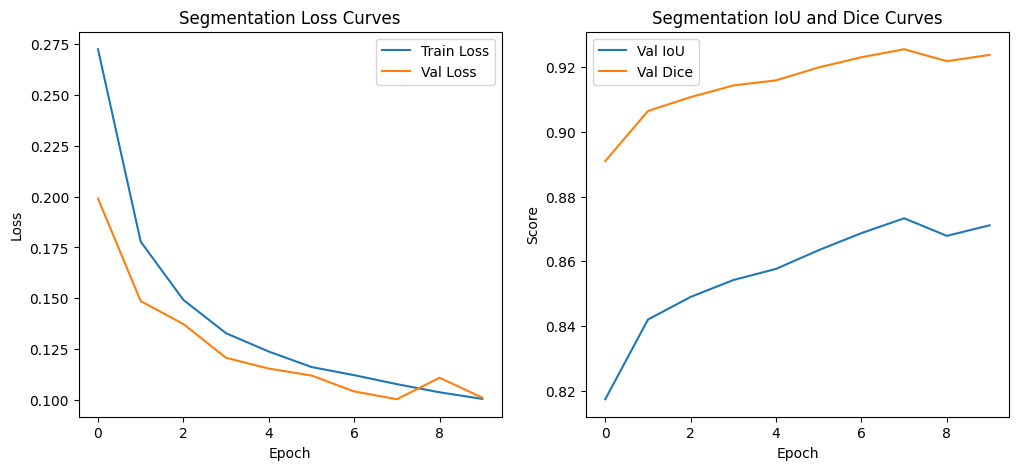

In [31]:
# Segmentation Training Curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_seg_loss_history, label='Train Loss')
plt.plot(val_seg_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Segmentation Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_seg_iou_history, label='Val IoU')
plt.plot(val_seg_dice_history, label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Segmentation IoU and Dice Curves')
plt.legend()
plt.show()

Example Segmentation

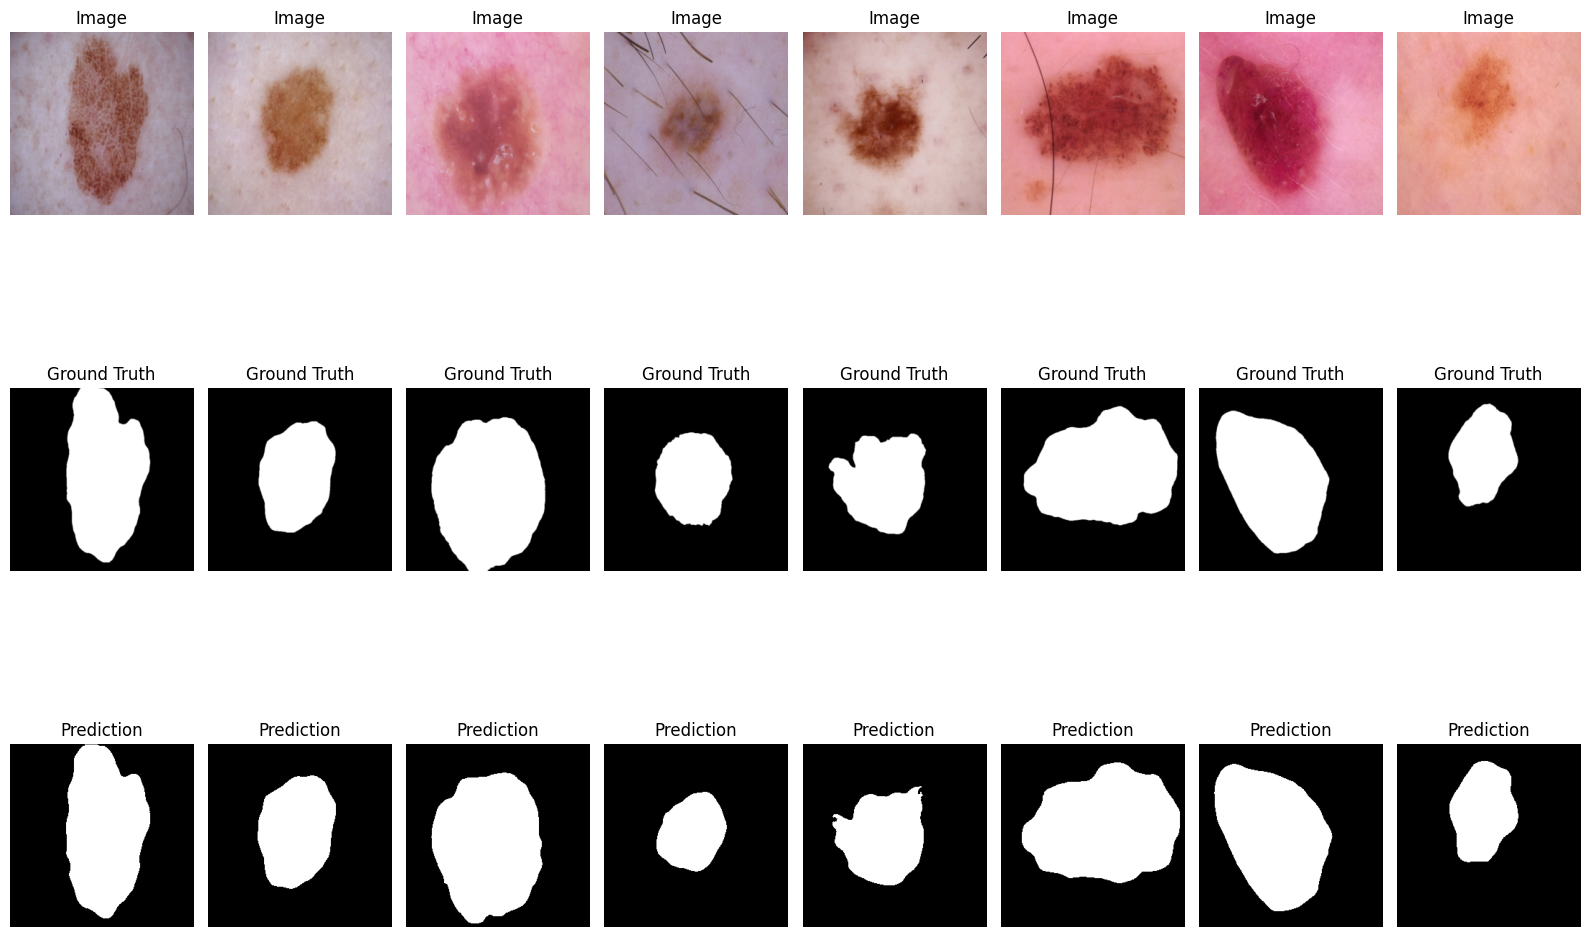

In [36]:
# Sample Segmentation Results from Test Set
model_seg.eval()
with torch.no_grad():
    images, masks, _ = next(iter(test_loader_seg))
    images = images.to(device)
    outputs = model_seg(images)
    pred_masks = (torch.sigmoid(outputs) > 0.5).float().cpu()

num_examples = 8
plt.figure(figsize=(16, 12))
for i in range(num_examples):
    plt.subplot(3, num_examples, i+1)
    plt.imshow(images[i].cpu().permute(1, 2, 0))
    plt.title("Image")
    plt.axis("off")
    
    plt.subplot(3, num_examples, i+1+num_examples)
    plt.imshow(masks[i].cpu().squeeze(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")
    
    plt.subplot(3, num_examples, i+1+2*num_examples)
    plt.imshow(pred_masks[i].squeeze(), cmap="gray")
    plt.title("Prediction")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Bonus 1

## Utilize a Single Model for Both Scenarios

In [40]:
class MultiTaskModel(nn.Module):
    def __init__(self, num_classes=7):
        super(MultiTaskModel, self).__init__()
        # Shared backbone (using ResNet18 layers without the final pooling and fc)
        resnet = models.resnet18(pretrained=True)
        self.shared = nn.Sequential(*list(resnet.children())[:-2])  # output shape: (batch, 512, H, W)
        
        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, num_classes)
        
        # Segmentation head: a simple decoder (can be replaced with a more complex architecture)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        features = self.shared(x)  # shared feature maps
        # Classification branch
        cls_feat = self.avgpool(features)
        cls_feat = cls_feat.view(cls_feat.size(0), -1)
        class_out = self.classifier(cls_feat)
        # Segmentation branch
        seg_out = self.decoder(features)
        return class_out, seg_out

In [41]:
# Example usage and training loop for multi-task model:
multi_task_model = MultiTaskModel(num_classes=7).to(device)
criterion_multi_cls = nn.CrossEntropyLoss()
criterion_multi_seg = nn.BCEWithLogitsLoss()
optimizer_multi = optim.Adam(multi_task_model.parameters(), lr=1e-4)


Train the model

In [45]:
# Ensure both DataLoaders use the same batch size, e.g., 32.
train_loader_cls = DataLoader(train_dataset_cls, batch_size=32, shuffle=True, num_workers=4)
train_loader_seg = DataLoader(train_dataset_seg, batch_size=32, shuffle=True, num_workers=4)

num_epochs_multi = 10
for epoch in range(num_epochs_multi):
    multi_task_model.train()
    running_loss = 0.0
    total_cls_correct = 0
    total_cls_samples = 0
    
    for (images_cls, labels_cls), (images_seg, masks_seg, _) in zip(train_loader_cls, train_loader_seg):
        images_cls = images_cls.to(device)
        labels_cls = labels_cls.to(device)
        images_seg = images_seg.to(device)
        masks_seg = masks_seg.to(device)
        
        optimizer_multi.zero_grad()
        # Use images from classification loader (or segmentation—they should have same transforms)
        cls_out, seg_out = multi_task_model(images_cls)
        
        # If seg_out's spatial dimensions differ, you can upsample it:
        seg_out = torch.nn.functional.interpolate(seg_out, size=masks_seg.shape[2:], mode='bilinear', align_corners=False)
        
        loss_cls = criterion_multi_cls(cls_out, labels_cls)
        loss_seg = criterion_multi_seg(seg_out, masks_seg)
        loss = loss_cls + loss_seg  # Optionally weight the losses
        loss.backward()
        optimizer_multi.step()
        
        running_loss += loss.item() * images_cls.size(0)
        _, preds = torch.max(cls_out, 1)
        total_cls_correct += (preds == labels_cls).sum().item()
        total_cls_samples += labels_cls.size(0)
    
    epoch_loss = running_loss / len(train_loader_cls.dataset)
    epoch_cls_acc = total_cls_correct / total_cls_samples
    print(f"Multi-task Epoch {epoch+1}/{num_epochs_multi} Loss: {epoch_loss:.4f} Classification Acc: {epoch_cls_acc:.4f}")

Multi-task Epoch 1/10 Loss: 0.6474 Classification Acc: 0.9157
Multi-task Epoch 2/10 Loss: 0.4943 Classification Acc: 0.9703
Multi-task Epoch 3/10 Loss: 0.4576 Classification Acc: 0.9832
Multi-task Epoch 4/10 Loss: 0.4605 Classification Acc: 0.9795
Multi-task Epoch 5/10 Loss: 0.4344 Classification Acc: 0.9883
Multi-task Epoch 6/10 Loss: 0.4493 Classification Acc: 0.9820
Multi-task Epoch 7/10 Loss: 0.4164 Classification Acc: 0.9929
Multi-task Epoch 8/10 Loss: 0.4626 Classification Acc: 0.9763
Multi-task Epoch 9/10 Loss: 0.4174 Classification Acc: 0.9924
Multi-task Epoch 10/10 Loss: 0.4151 Classification Acc: 0.9930


Evaluate the model

In [48]:
# -- Classification Evaluation --
multi_task_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader_cls:
        images = images.to(device)
        cls_out, _ = multi_task_model(images)
        _, preds = torch.max(cls_out, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score, confusion_matrix
test_acc_multi = accuracy_score(all_labels, all_preds)
cm_multi = confusion_matrix(all_labels, all_preds)
print("Multi-task Model Classification Test Accuracy:", test_acc_multi)
print("Multi-task Model Classification Confusion Matrix:\n", cm_multi)
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=list(label_mapping.keys())))


Multi-task Model Classification Test Accuracy: 0.8449767132401863
Multi-task Model Classification Confusion Matrix:
 [[ 60  82   1   8  12   2   2]
 [  7 980   2   5  12   0   0]
 [  0  10  52  12   2   1   0]
 [  2   0   5  38   2   1   1]
 [  8  34   2   8 112   1   0]
 [  1   1   0   2   1  12   0]
 [  0   5   0   0   0   1  16]]
Classification Report:
               precision    recall  f1-score   support

         MEL       0.77      0.36      0.49       167
          NV       0.88      0.97      0.93      1006
         BCC       0.84      0.68      0.75        77
       AKIEC       0.52      0.78      0.62        49
         BKL       0.79      0.68      0.73       165
          DF       0.67      0.71      0.69        17
        VASC       0.84      0.73      0.78        22

    accuracy                           0.84      1503
   macro avg       0.76      0.70      0.71      1503
weighted avg       0.84      0.84      0.83      1503



In [50]:
import torch.nn.functional as F

# --- Segmentation Evaluation for Multi-task Model ---
test_seg_loss = 0.0
total_iou = 0.0
total_dice = 0.0
count = 0
with torch.no_grad():
    for images, masks, _ in test_loader_seg:
        images = images.to(device)
        masks = masks.to(device)
        # Get segmentation output from multi-task model
        _, seg_out = multi_task_model(images)
        # Upsample segmentation output to match the size of the ground truth masks
        seg_out = F.interpolate(seg_out, size=masks.shape[2:], mode='bilinear', align_corners=False)
        # Now compute the loss with matching dimensions
        loss = criterion_multi_seg(seg_out, masks)
        test_seg_loss += loss.item() * images.size(0)
        total_iou += iou_score(seg_out, masks)
        total_dice += dice_coeff(seg_out, masks)
        count += 1

test_seg_loss /= len(test_loader_seg.dataset)
avg_iou = total_iou / count
avg_dice = total_dice / count
print("Multi-task Model Segmentation Test Loss: {:.4f}".format(test_seg_loss))
print("Multi-task Model Segmentation Test IoU: {:.4f}".format(avg_iou))
print("Multi-task Model Segmentation Test Dice: {:.4f}".format(avg_dice))


Multi-task Model Segmentation Test Loss: 0.3912
Multi-task Model Segmentation Test IoU: 0.4730
Multi-task Model Segmentation Test Dice: 0.6216


Example samples

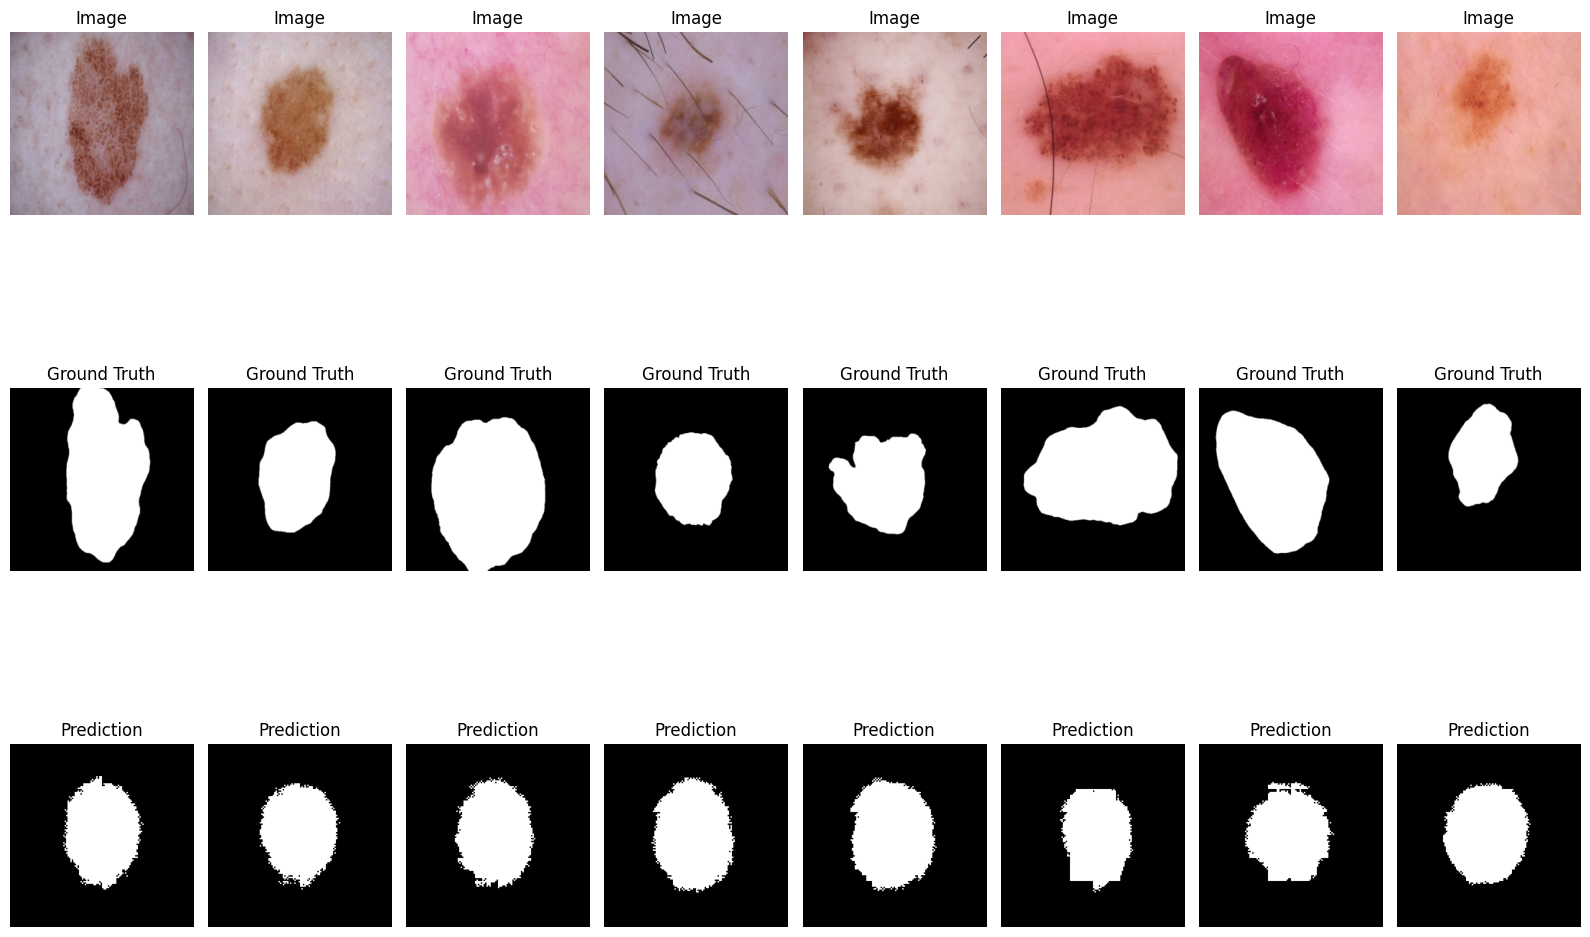

In [51]:
multi_task_model.eval()
with torch.no_grad():
    images, masks, _ = next(iter(test_loader_seg))
    images = images.to(device)
    # Get segmentation output from the multi-task model
    _, seg_out = multi_task_model(images)
    pred_masks = (torch.sigmoid(seg_out) > 0.5).float().cpu()

num_examples = 8
plt.figure(figsize=(16, 12))
for i in range(num_examples):
    # Original image
    plt.subplot(3, num_examples, i+1)
    plt.imshow(images[i].cpu().permute(1, 2, 0))
    plt.title("Image")
    plt.axis("off")
    
    # Ground Truth mask
    plt.subplot(3, num_examples, i+1+num_examples)
    plt.imshow(masks[i].cpu().squeeze(), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")
    
    # Predicted mask
    plt.subplot(3, num_examples, i+1+2*num_examples)
    plt.imshow(pred_masks[i].squeeze(), cmap="gray")
    plt.title("Prediction")
    plt.axis("off")
plt.tight_layout()
plt.show()
